# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-HES-ALM/master/main/ds-masters/content/images/hes-logo.png"> CSCI E-82: Advanced ML, Data Mining and AI
</br>


**Harvard Extension School - Fall 2024**<br/>

**Homework 5**: </br>

**Professor**: Dr. Peter V. Henstock<br/>

**Team Name**: The Spice Analysts</br>
**Students**: Daniel More Torres and Michael Assmus</br>

**Due Date**: 25/Nov/2024, 8:00pm EST</br>

----

<hr style="height:2pt">

In [104]:
# RUN THIS CELL TO GET CSS Styles for CSC-S-82
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-HES-ALM/master/main/master/content/styles/"
    "csci-e-82.css"
).text

**Load all libraries needed for our homework**

In [105]:
import string
import re
import pandas as pd # pip install pandas
import numpy as np
import matplotlib.pyplot as plt # pip install matplotlib
import seaborn as sns # pip install seaborn
import pickle
import time

from sklearn import manifold

import nltk # pip install nltk
from nltk.corpus import stopwords 
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('punkt')


from nltk.stem.porter import PorterStemmer

import spacy # pip install spacy

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer # pip install scikit-learn
from sklearn.metrics.pairwise import cosine_similarity
import gensim # pip install gensim
from gensim.models import word2vec  #pip install word2vec

# from wordcloud import WordCloud  # pip install wordcloud
# from textblob import TextBlob  # Sentiment Analysis - pip install textblob
# from sentence_transformers import SentenceTransformer, util # pip install sentence_transformers

In [106]:
# Record start time
start_time = time.perf_counter()

In [107]:
# Load debate dataset
debate_df = pd.read_csv('data/debates.csv', encoding='latin1')
display(debate_df.head())
len(debate_df['event_id'].unique())

,event_id,speaker_names_raw,rawtext,Order,Year,Party,PartyWin,Round,AgeDem,AgeRep,AgeDiff,InflationRate,GDPgrowth
0,1960_KennedyNixon_Rd1,KENNEDY,"Mr. Smith, Mr. Nixon. In the election of 1860...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN
1,1960_KennedyNixon_Rd1,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,1960,republican,democrat,1,43,47,4,1.46,NaN
2,1960_KennedyNixon_Rd1,KENNEDY,"Well, the Vice President and I came to the Co...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN
3,1960_KennedyNixon_Rd1,NIXON,I have no comment.,1,1960,republican,democrat,1,43,47,4,1.46,NaN
4,1960_KennedyNixon_Rd1,NIXON,It would be rather difficult to cover them in...,1,1960,republican,democrat,1,43,47,4,1.46,NaN


31

In [108]:
# Check debate year range
debate_df['Year'].min(), debate_df['Year'].max()

(1960, 2020)

In [109]:
# Inspect example debate text
debate_df.loc[396:398,'rawtext']

396    And I havenÕt got time to answer with regard t...
397                                                  NaN
398     Mr. President, if I heard you correctly, you ...
Name: rawtext, dtype: object

In [110]:
from collections import Counter

# Concatenate all text into a single string
all_text = '|'.join(debate_df.loc[debate_df['rawtext'].notna(), 'rawtext'])

# Extract special characters (non-alphanumeric and non-whitespace)
special_chars = re.findall(r'[^\w\s]', all_text)

# Count frequencies
freq = Counter(special_chars)
freq

Counter({'.': 24886,
         ',': 21801,
         '|': 6850,
         '-': 1807,
         '?': 924,
         '$': 690,
         ';': 458,
         ':': 227,
         '%': 109,
         '[': 62,
         ']': 62,
         '/': 54,
         '(': 37,
         ')': 37,
         "'": 24,
         '\x89': 19,
         '\\': 12,
         '&': 5,
         '´': 4,
         '!': 3,
         '`': 2,
         '\x9d': 2,
         '+': 2,
         '>': 1})

In [111]:
indices = debate_df[debate_df['rawtext'].str.contains('\x89', na=False)]
indices

,event_id,speaker_names_raw,rawtext,Order,Year,Party,PartyWin,Round,AgeDem,AgeRep,AgeDiff,InflationRate,GDPgrowth
673,1988_BushDukakis_Rd1,DUKAKIS,"So, IÕm for continued research, but I also wan...",14,1988,republican,republican,1,64,55,9,4.08,4.18
701,1988_BushDukakis_Rd1,DUKAKIS,A report on international terrorism chaired by...,14,1988,republican,republican,1,64,55,9,4.08,4.18
714,1988_BushDukakis_Rd1,DUKAKIS,But I didnÕt pick Lloyd Bentsen because he was...,14,1988,republican,republican,1,64,55,9,4.08,4.18
729,1988_BushDukakis_Rd1,BUSH,I want to see asymmetrical reductions in conve...,14,1988,democrat,republican,1,64,55,9,4.08,4.18
891,1996_ClintonBillDole_Rd1,DOLE,"Well, I have a different view. Again, IÛªve ...",16,1996,republican,democrat,1,50,73,23,2.93,3.77
1001,1996_ClintonBillDole_Rd2,CLINTON_BILL,I donÕt have time in 30 seconds to respond to...,17,1996,democrat,democrat,2,50,73,23,2.93,3.77
1146,2000_BushWGore_Rd1,BUSH_W,"IÕve been standing up to big Hollywood, big t...",18,2000,republican,republican,1,52,54,2,3.38,4.08
1154,2000_BushWGore_Rd1,GORE,"If I could respond, Jim. What heÕs quoting is...",18,2000,democrat,republican,1,52,54,2,3.38,4.08
1218,2000_BushWGore_Rd2,BUSH_W,Let me comment on that. IÕm not so sure the r...,19,2000,republican,republican,2,52,54,2,3.38,4.08
1664,2004_BushWKerry_Rd1,BUSH_W,And I think this will work. ItÕs not going to ...,21,2004,republican,republican,1,61,58,3,2.68,3.85


In [112]:
indices.iloc[0]['rawtext']

'So, IÕm for continued research, but I also want strong conventional forces. Now, the other day, Mr. Bush said, \x89ä´Well, if we continue with Star War-Star Wars-we have to cut some place.\x89ä_ He hasnÕt told us where. We know where theyÕre cutting. We know where youÕre cutting right now. YouÕre cutting into the fiber and muscle of our conventional forces. YouÕre cutting back on maintenance and equipment.'

Special handling for special characters:
- \+ is fine. It's only used in "AOC+3", which is a group name.
- \> is part of a "> Transfer interrupted!" message. We should probably drop that segment.
- \x89Û\x9d seems to be close quotes. It has \x89ÛÏ as the open quotes counterpart.
- \ \1/2\ \ and similar fractions are apparently actual fractions. That one is "1/2" and there are other fraction versions.
- Pretty sure Ñ is -.
- Õ is '
- É might be em-dash or ellipses
- Ð is probably ellipses?
- There are a number of instances of [laughter], [crosstalk], [applause], and possibly others.

In [113]:
remap = {"\x89Û\x9d": '"', "Ñ": "-", "Õ": "'", "É": "", "Ð": "", "\x89": "", "ä": ""}
remap

{'\x89Û\x9d': '"', 'Ñ': '-', 'Õ': "'", 'É': '', 'Ð': '', '\x89': '', 'ä': ''}

In [114]:
# Replace characters in the 'rawtext' column
for key, value in remap.items():
    debate_df['rawtext'] = debate_df['rawtext'].str.replace(key, value)

In [115]:
debate_df.iloc[673]['rawtext']

"So, I'm for continued research, but I also want strong conventional forces. Now, the other day, Mr. Bush said, ´Well, if we continue with Star War-Star Wars-we have to cut some place._ He hasn't told us where. We know where they're cutting. We know where you're cutting right now. You're cutting into the fiber and muscle of our conventional forces. You're cutting back on maintenance and equipment."

In [116]:
# Make functions for text cleaning
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))

def lower_case(text):
    try:
        text = text.lower()
    except:
        return text
    return text

def remove_punctuation(text):
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    return text


def clean_text_nltk(text):
    # Tokenize the text
    try:
        tokens = word_tokenize(text.lower())  # Convert to lowercase and tokenize
    except:
        tokens = text
    # Remove punctuation
    tokens = [word for word in tokens if word not in string.punctuation]
    # Join tokens back into a string
    return ' '.join(tokens)

def remove_stopwords(text):
    tokens = word_tokenize(text)  # Tokenize
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return ' '.join(filtered_tokens)

lemmatizer = WordNetLemmatizer()
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(lemmatized_tokens)

In [117]:
debate_df.shape

(6852, 13)

In [118]:
debate_df = debate_df[~debate_df['rawtext'].isna()].copy()
debate_df

,event_id,speaker_names_raw,rawtext,Order,Year,Party,PartyWin,Round,AgeDem,AgeRep,AgeDiff,InflationRate,GDPgrowth
0,1960_KennedyNixon_Rd1,KENNEDY,"Mr. Smith, Mr. Nixon. In the election of 1860...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN
1,1960_KennedyNixon_Rd1,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,1960,republican,democrat,1,43,47,4,1.46,NaN
2,1960_KennedyNixon_Rd1,KENNEDY,"Well, the Vice President and I came to the Co...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN
3,1960_KennedyNixon_Rd1,NIXON,I have no comment.,1,1960,republican,democrat,1,43,47,4,1.46,NaN
4,1960_KennedyNixon_Rd1,NIXON,It would be rather difficult to cover them in...,1,1960,republican,democrat,1,43,47,4,1.46,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6847,2020_BidenTrump_Rd2,TRUMP,Is he gonna get China to do it? Is he going t...,35,2020,republican,democrat,2,78,74,4,1.23,-2.77
6848,2020_BidenTrump_Rd2,BIDEN,"No, I'm going to rejoin the Paris Accord and ...",35,2020,democrat,democrat,2,78,74,4,1.23,-2.77
6849,2020_BidenTrump_Rd2,TRUMP,That'll cost you $1 trillion.,35,2020,republican,democrat,2,78,74,4,1.23,-2.77
6850,2020_BidenTrump_Rd2,TRUMP,We have to make our country totally successfu...,35,2020,republican,democrat,2,78,74,4,1.23,-2.77


In [119]:
debate_df['cleaned_text'] = debate_df['rawtext'].str.lower()
debate_df.head()

,event_id,speaker_names_raw,rawtext,Order,Year,Party,PartyWin,Round,AgeDem,AgeRep,AgeDiff,InflationRate,GDPgrowth,cleaned_text
0,1960_KennedyNixon_Rd1,KENNEDY,"Mr. Smith, Mr. Nixon. In the election of 1860...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN,"mr. smith, mr. nixon. in the election of 1860..."
1,1960_KennedyNixon_Rd1,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,1960,republican,democrat,1,43,47,4,1.46,NaN,"mr. smith, senator kennedy. the things that s..."
2,1960_KennedyNixon_Rd1,KENNEDY,"Well, the Vice President and I came to the Co...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN,"well, the vice president and i came to the co..."
3,1960_KennedyNixon_Rd1,NIXON,I have no comment.,1,1960,republican,democrat,1,43,47,4,1.46,NaN,i have no comment.
4,1960_KennedyNixon_Rd1,NIXON,It would be rather difficult to cover them in...,1,1960,republican,democrat,1,43,47,4,1.46,NaN,it would be rather difficult to cover them in...


In [ ]:
# for ix, row in enumerate(debate_df.iterrows()):
#     try:
#         debate_df.loc[ix, 'cleaned_text'] = clean_text_nltk(row[1]['rawtext'])
#     except Exception as e:
#         print(f"Error at index {ix}: {e}")


In [120]:
# Clean speech dataset
debate_df['cleaned_text'] = debate_df['rawtext'].str.lower()
debate_df['cleaned_text'] = debate_df['cleaned_text'].apply(remove_punctuation)
debate_df['cleaned_text'] = debate_df['cleaned_text'].apply(remove_stopwords)
debate_df['cleaned_text'] = debate_df['cleaned_text'].apply(lemmatize_text)

In [122]:
debate_df.head()

,event_id,speaker_names_raw,rawtext,Order,Year,Party,PartyWin,Round,AgeDem,AgeRep,AgeDiff,InflationRate,GDPgrowth,cleaned_text
0,1960_KennedyNixon_Rd1,KENNEDY,"Mr. Smith, Mr. Nixon. In the election of 1860...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN,mr smith mr nixon election abraham lincoln sai...
1,1960_KennedyNixon_Rd1,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,1960,republican,democrat,1,43,47,4,1.46,NaN,mr smith senator kennedy thing senator kennedy...
2,1960_KennedyNixon_Rd1,KENNEDY,"Well, the Vice President and I came to the Co...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN,well vice president came congress together ser...
3,1960_KennedyNixon_Rd1,NIXON,I have no comment.,1,1960,republican,democrat,1,43,47,4,1.46,NaN,comment
4,1960_KennedyNixon_Rd1,NIXON,It would be rather difficult to cover them in...,1,1960,republican,democrat,1,43,47,4,1.46,NaN,would rather difficult cover eight two half mi...


### Check if possitive of negative message have evolved over time
Before we start, let's check if there are any other trends on the dataset that could influence the variable we want to analyze

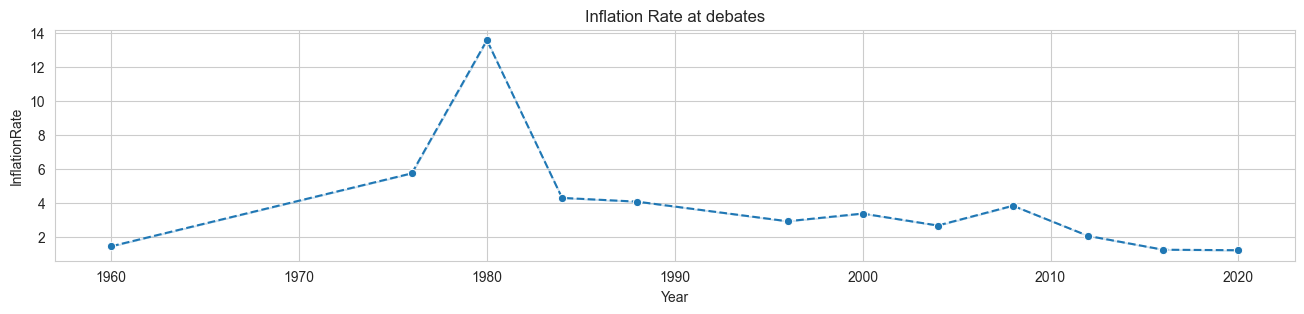

In [159]:
plt.figure(figsize=(16, 3))  # Set the figure size
sns.set_style('whitegrid')
sns.lineplot(data=debate_df, x='Year', y='InflationRate', marker='o', linestyle='--')
plt.title('Inflation Rate at debates');

Highest inflation during the 1980 debate, followed by 1976. Remainig ones belows 4%. Would the party in power send a more possitive message than the challenger during times or higher inflation?

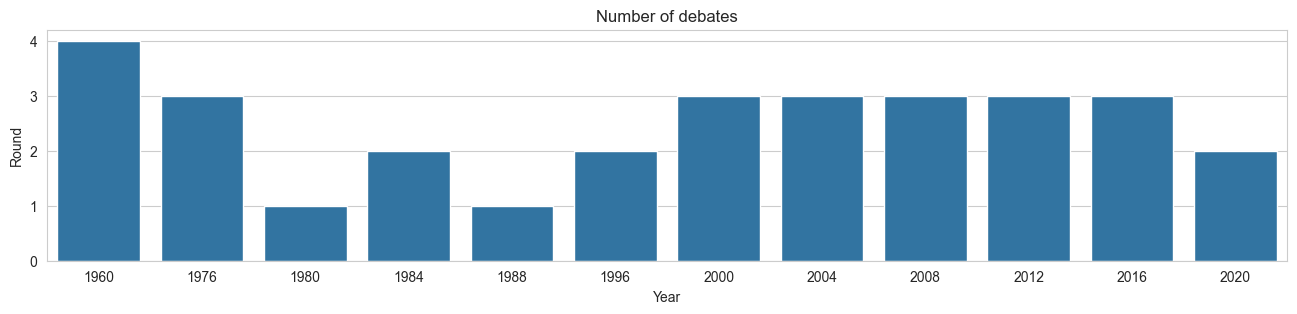

In [170]:
plt.figure(figsize=(16, 3))  # Set the figure size
sns.set_style('whitegrid')
sns.barplot(data=debate_df, x='Year', y='Round', estimator='max')

plt.title('Number of debates');


In [ ]:
plt.figure(figsize=(16, 3))  # Set the figure size
sns.set_style('whitegrid')
sns.lineplot(data=debate_df, x='Year', y='AgeDem', label='Age Democrat', marker='o',linestyle='--')
sns.lineplot(data=debate_df, x='Year', y='AgeRep', label='Age Republican', marker='o', linestyle='--')
sns.lineplot(data=debate_df, x='Year', y='AgeDiff', label='AgeDiff', marker='o')

plt.title('Inflation Rate at debates');

A possitive trend on the age of candidates. Would that influence the possitivity or negativity of the message?

In [127]:
debate_df[['speaker_names_raw', 'Order', 'Year', 'Round']].drop_duplicates()

,speaker_names_raw,Order,Year,Round
0,KENNEDY,1,1960,1
1,NIXON,1,1960,1
29,NIXON,2,1960,2
30,KENNEDY,2,1960,2
55,KENNEDY,3,1960,3
...,...,...,...,...
5670,TRUMP,33,2016,3
6023,BIDEN,34,2020,1
6024,TRUMP,34,2020,1
6648,TRUMP,35,2020,2


In [173]:
from textblob import TextBlob

# Function to calculate sentiment polarity
def get_sentiment(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity  # Polarity ranges from -1 (negative) to 1 (positive)


In [175]:
debate_df['polarity'] = debate_df['cleaned_text'].apply(get_sentiment)
debate_df.head(2)

,event_id,speaker_names_raw,rawtext,Order,Year,Party,PartyWin,Round,AgeDem,AgeRep,AgeDiff,InflationRate,GDPgrowth,cleaned_text,polarity
0,1960_KennedyNixon_Rd1,KENNEDY,"Mr. Smith, Mr. Nixon. In the election of 1860...",1,1960,democrat,democrat,1,43,47,4,1.46,NaN,mr smith mr nixon election abraham lincoln sai...,0.189010
1,1960_KennedyNixon_Rd1,NIXON,"Mr. Smith, Senator Kennedy. The things that S...",1,1960,republican,democrat,1,43,47,4,1.46,NaN,mr smith senator kennedy thing senator kennedy...,0.052576


In [184]:
debate_df['Year'].unique()

array([1960, 1976, 1980, 1984, 1988, 1996, 2000, 2004, 2008, 2012, 2016,
       2020])

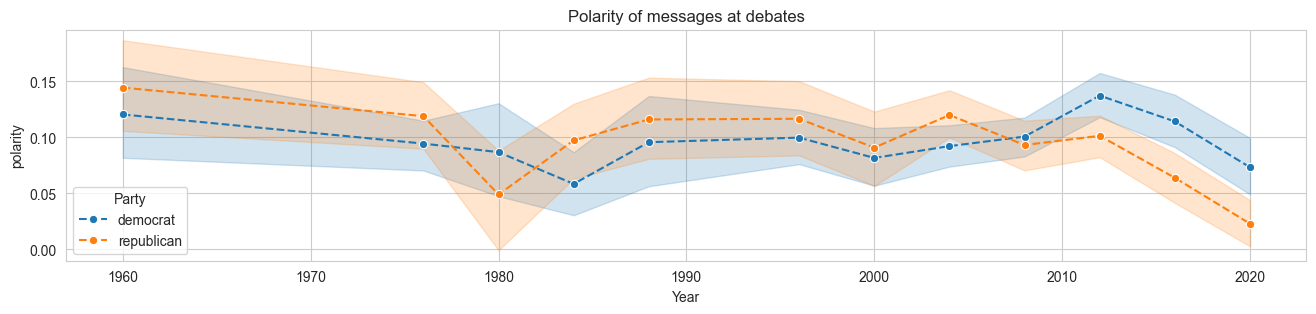

In [178]:
plt.figure(figsize=(16, 3))  # Set the figure size
sns.set_style('whitegrid')
sns.lineplot(data=debate_df, x='Year', y='polarity', marker='o', linestyle='--', hue='Party')
plt.title('Polarity of messages at debates');

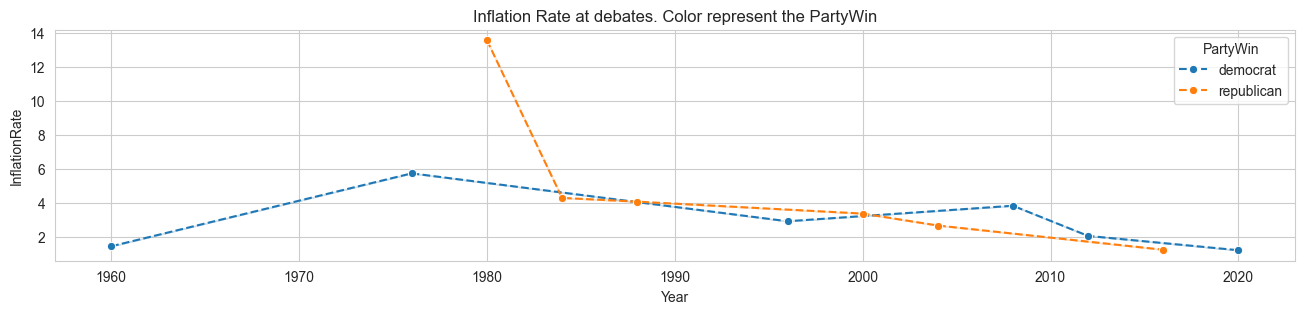

In [182]:
plt.figure(figsize=(16, 3))  # Set the figure size
sns.set_style('whitegrid')
sns.lineplot(data=debate_df, x='Year', y='InflationRate', marker='o', linestyle='--', hue='PartyWin')
plt.title('Inflation Rate at debates. Color represent the PartyWin');

PartyWin is the party that won the election after the debate. So in 1980 the party in power was DEM. 

### Speeches

In [ ]:
# Load speeches dataset
speech_df = pd.read_json('data/speeches.json')
display(speech_df.head())
len(speech_df['doc_name'].unique())

In [ ]:
# Check speeches date range
speech_df['date'].min(), speech_df['date'].max()

In [ ]:
# Clean speech dataset
speech_df['cleaned_text'] = speech_df['transcript'].apply(lower_case)
speech_df['cleaned_text'] = speech_df['cleaned_text'].apply(remove_punctuation)
speech_df['cleaned_text'] = speech_df['cleaned_text'].apply(remove_stopwords)
speech_df['cleaned_text'] = speech_df['cleaned_text'].apply(lemmatize_text)

In [ ]:
# Check cleaned dataset
speech_df.head()

<a id='#Hours-Invested'></a>

#### Hours Invested

164 hours

<a id='#Time-for-notebook-to-run'></a>

#### Time for notebook to run


In [ ]:
print(f"It took {(time.perf_counter() - start_time)/60:.2f} minutes for this notebook to run ")